# **PROYECTO PREPARACIÓN DE DATOS**

### Importamos todo lo necesario

In [34]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin
from sklearn import preprocessing
from sklearn import neighbors
from imblearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.diagnostic import lilliefors
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from imblearn.combine import SMOTETomek
from sklearn import metrics
pd.options.display.max_rows = None #Para controlar cuantas filas de los dataframes mostrar.
#pd.options.display.max_columns = 200 #Para controlar cuantas columnas de los dataframes mostrar.
import warnings
warnings.filterwarnings('ignore') #Para ignorar (o no) las advertencias.

### Procesamiento preliminar de los datos

Leemos los datos y separamos las variables de entrada y la variable de salida (Tier)

In [35]:
#Primero, leemos el archivo csv. Está separado por puntos y comas.
datos = pd.read_csv('pokemon-data.csv',delimiter =';')
y = datos.loc[:,'Tier'].copy()
X = datos.loc[:,datos.columns != 'Tier'].copy()

Ponemos los índices de ambos DataFrames

In [36]:
X.index = X['Name']
y.index = X['Name']

Eliminación de las "Megaevoluciones" por comodidad. La explicación está en el apartado de los outilers

In [37]:
indices_mega = X[X['Name'].str.contains("Mega", case=False, na=False)].index
X = X.drop(indices_mega)
y = y.drop(indices_mega)

Creamos una función que nos permita convertir el problema de clasificación multiclase en un problema de clasificación binario. Para ello, vamos a convertir las tiers de 'AG', 'UBER' y 'OU' en "Bueno" (1) y el resto de tiers en "Malo" (0). La clase positiva será 1, ya que hay menos Pokémon buenos competitivamente que Pokémon malos. Esto lo vamos a aplicar en todo el dataset, no sólo en el conjunto de entrenamiento. Además, como vamos a utilizar codificación basada en la salida para algunas columnas, será necesario aplicar este categorizador ANTES de la codificación.

In [38]:
class TierCategorizer(TransformerMixin):
    def __init__(self, columns=None): #Si recibimos algo
        self.columns = columns

    def fit(self, X):
        X=pd.DataFrame(X) #Por si recibiéramos un array de numpy
        if self.columns == None:
            self.columns=X.columns
        return self
    
    def transform(self,X):
        X = pd.DataFrame(X)
        yaux = X.copy()
        tiers = np.where(np.logical_or(yaux.loc[:,'Tier'] == 'OU', yaux.loc[:,'Tier'] == 'Uber', yaux.loc[:,'Tier'] == 'AG'), 1, 0)
        yaux.loc[:,'Tier'] = tiers
        return yaux

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return self

In [39]:
CategTipos = TierCategorizer()
CategTipos = CategTipos.fit(y)
y_transformed = CategTipos.transform(y)

### Codificación de las variables categóricas

Para la columna de movimientos, vamos a realizar una codificación propia que consiste en contar los movimientos que aprende cada Pokémon. En princpio, tener acceso a más movimientos es ventajoso competitivamente, por lo que merece la pena considerar esta variable. En el dataset había un error, ya que el Pokémon **Smeargle** es capaz de aprender todos los movimientos del juego. Lo corregimos "manualmente" en esta función.

In [40]:
class MovementCounter(TransformerMixin):
    def __init__(self, columns=None): #Si recibimos algo
        self.columns = columns

    def fit(self, X, y=None):
        X=pd.DataFrame(X) #Por si recibiéramos un array de numpy
        y=pd.DataFrame(y)
        if self.columns == None:
            self.columns=X.columns
        return self
        
    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        Xaux = X.copy()
        Xaux['Moves'] = Xaux['Moves'].astype(str).str.count(',') + 1
        #Smeargle aprende todos los movimientos, pero no está reflejado en el dataset.
        
        if 'Smeargle' in Xaux.index:
            Xaux.loc['Smeargle','Moves'] = 676
            
        
        return Xaux

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return self

La columna de tipos vamos a desdoblarla, ya que considerar las combinaciones de tipos provocará que la variable Tipos pueda tomar muchos valores diferentes, muchos de ellos con muy pocos ejemplos. Para mejorar la calidad del aprendizaje, vamos a reducir el número de valores que puede tomar esta variable generando dos variables a partir de esta (Tipo 1 y Tipo 2). Algunos Pokémon tienen dos tipos, y otros sólo uno. Para estos últimos, consideraremos que su tipo 2 es "nulo" (como si fuera otro tipo).

In [41]:
class TypeCategorizer(TransformerMixin):
    # Constructor de la clase
    def __init__(self, columns=None): #Si recibimos algo
        self.columns = columns

    #Fit
    def fit(self, X, y=None):
        X=pd.DataFrame(X) #Por si recibiéramos un array de numpy
        if self.columns == None:
            self.columns=X.columns
        return self

    #Transform
    def transform(self, X, y=None):
        #Creamos una copia de X para no perder los datos originales
        Xaux=X.copy()
        #Accedemos a la columna de tipos, y rellenamos las columnas acorde
        for c in self.columns:
            caracteresAEliminar = ["[", "]", "'"]
            for char in caracteresAEliminar:
                Xaux.loc[:,c]= Xaux.loc[:,c].str.replace(char,'')
            #Después, para los Pokémon que solo tienen un tipo, vamos a añadirles un segundo tipo "nulo"
            Xaux[['Type 1', 'Type 2']] = Xaux.loc[:,c].str.split(',', expand=True) #Expand true para que cree dos nuevas columnas

            #Por último, hay que borrar la columna de "Types" original
            Xaux=Xaux.drop(["Types"], axis=1)
            Xaux = pd.DataFrame(Xaux)
        return Xaux

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return self

Para la columna de habilidades, vamos a proceder de forma similar. Cada Pokémon puede tener hasta 3 habilidades, pero hay Pokémon que sólo tienen 1 ó 2. Tratar la lista de habilidades como variable categórica es una mala idea ya que esa variable tendrá casi tantos valores como ejemplos. Desdoblando la columna de habilidades en 3, conseguimos suavizar hasta cierto punto este problema (aunque no del todo ya que hay muchas más habilidades que tipos)

In [42]:
def countCaracter(text, character):
    apariciones=0
    for char in text:
        if char==character:
            apariciones+=1
    return apariciones

class AbilityCategorizer(TransformerMixin):
    # Constructor de la clase
    def __init__(self, columns=None): #Si recibimos algo
        self.columns = columns

    #Fit
    def fit(self, X, y=None):
        X=pd.DataFrame(X) #Por si recibiéramos un array de numpy
        if self.columns == None:
            self.columns=X.columns
        return self

    #Transform
    def transform(self, X, y=None):
        #Creamos una copia de X para no perder los datos originales
        Xaux=X.copy()
        #Accedemos a la columna de habilidades, y modificamos las columnas acorde
        for c in self.columns:
            caracteresAEliminar = ["[", "]", "'"]
            for char in caracteresAEliminar:
                Xaux.loc[:,c]= Xaux.loc[:,c].str.replace(char,'')
            #Para los Pokémon que tienen sólo una habilidad, vamos a añadirles dos habilidades nulas; y para los
            #que tengan 2 habilidades, les añadimos una extra.
            for poke in Xaux.loc[:,c].index:
                if countCaracter(Xaux.loc[poke,c], ",")==0:
                    Xaux.loc[poke,c]=Xaux.loc[poke,c]+", None, None"
                elif countCaracter(Xaux.loc[poke,c], ",")==1:
                    Xaux.loc[poke,c]=Xaux.loc[poke,c]+", None"
                #Hay 2 Pokémon que tienen 4 habilidades, pero no vamos a crear una nueva columna para ellos
                elif countCaracter(Xaux.loc[poke,c], ",")==3:
                    #Sacamos el índice de la tercera coma y borramos todo lo que esté después
                    numeroComas=0
                    for i, char in enumerate(Xaux.loc[poke,c]):
                        if char==",":
                            numeroComas+=1
                        if numeroComas==3:
                            indexComa=i
                            break
                    Xaux.loc[poke,c] = Xaux.loc[poke,c][:indexComa]
                        
            #Creamos tres columnas nuevas
            Xaux[['Ability 1', 'Ability 2', 'Ability 3']] = Xaux.loc[:,c].str.split(',', expand=True)
            #Por último, hay que borrar la columna de "Abilities" original
            if 'Abilities' in Xaux.columns:
                Xaux=Xaux.drop(["Abilities"], axis=1)
            Xaux = pd.DataFrame(Xaux)
        return Xaux

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return self

La columna de "siguientes evoluciones" puede tener relevancia ya que los Pokémon que todavía pueden evolucionar pueden utilizar un objeto llamado Mineral Evolutivo, que aumenta sus defensas en un 50%. No nos importa tanto si el Pokémon puede evolucionar una vez, dos veces o si tiene diferentes posibles evoluciones; solo si es capaz de evolucionar. Por lo tanto, codificaremos esta columna de la siguiente manera: si el Pokémon tiene alguna evolución posible, le asignaremos el valor 1; en caso contrario, le asignaremos el valor 0. Para ello, vamos a modificar la columna aplicándole un tratamiento: si el Pokémon puede evolucionar (si el dato de la columna no es '[]') le asignaremos un 1, y en caso contrario le asignaremos un 0.

No utilizamos una codificación One Hot, ya que crearíamos dos columnas opuestas. Como más aadelante vamos a realizar el análisis de correlaciones, si creamos dos columnas de esta forma, una será eliminada, por lo que usar One Hot es poco eficiente computacionalmente.

Además, hay algunos Pokémon que pueden tener formas alternativas (que no se consideran evoluciones, por lo que no permiten el uso del Mineral Evolutivo) y que en el dataset presentan una lista no vacía en la columna de "siguientes evoluciones". Como no hay ningún criterio para detectar estos casos, los vamos a tratar manualmente. Estos Pokémon son **Giratina**, **Greninja**, **Kyurem**, **Landorus**, **Oricorio**, **Rotom**, **Shaymin**, **Thundurus**, **Tornadus** y **Zygarde**. Pese a que tengan una lista no vacía, estos Pokémon los vamos a codificar como que **no** tienen evolución

In [43]:
class EvolutionCategorizer(TransformerMixin):
    # Constructor de la clase
    def __init__(self, columns=None): #Si recibimos algo
        self.columns = columns

    #Fit
    def fit(self, X, y=None):
        X=pd.DataFrame(X) #Por si recibiéramos un array de numpy
        if self.columns == None:
            self.columns=X.columns
        return self

    #Transform
    def transform(self, X, y=None):
        #Creamos una copia de X para no perder los datos originales
        Xaux=X.copy()
        #Accedemos a la columna de tipos, y rellenamos las columnas acorde
        for c in self.columns:
            Xaux.loc[:,c] = np.where(Xaux.loc[:,c]=="[]", 0, 1)
            #Ahora, consideramos las excepciones descritas arriba
            pokemonEquivocados = ["Giratina", "Greninja", "Kyurem", "Landorus", "Oricorio", "Rotom", "Shaymin", "Thundurus", "Tornadus", "Zygarde"]
            for poke in pokemonEquivocados:
                # Si se encuentra el Pokémon en la columna (luego esto generaba problemas de dimensionalidad). Casteo como string para evitar problemas
                if Xaux[c].astype(str).str.contains(poke, na=False).any():
                    # Solo hacemos la asignación si encontramos el Pokémon
                    Xaux.loc[Xaux[c].astype(str).str.contains(poke, na=False), c] = 0 
        return Xaux

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return self

### Preprocesamiento de los datos

Vamos a ir creando Pipelines para cada una de las columnas de variables categóricas. De esa forma, luego podemos utilizar un objeto de la clase ColumnTransformer para aplicar a cada columna el tratamiento adecuado.

A la columna de nombres, como no tiene relevancia competitiva, vamos a aplicarle una codificación ordinal.

In [44]:
pipe_nombres = Pipeline([('Codificación ordinal', ce.OrdinalEncoder())])

A la columna de evoluciones sólo le aplicamos el `EvolutionCategorizer` : 

In [45]:
pipe_evoluciones = Pipeline([('Categorizador de evoluciones', EvolutionCategorizer())])

A la columna de tipos le aplicamos dos tratamientos: primero la desdoblamos y a las dos columnas resultantes les aplicamos una codificación basada en la salida, ya que los tipos son una variable categórica que puede tomar 18 valores (19 en el tipo 2 por el tipo "nulo"). Además, los tipos de un Pokémon tienen relevancia competitiva, por lo que tiene sentido aplicar esta codificación.

In [46]:
pipe_tipos = Pipeline([
    ('Categorizador de Tipos', TypeCategorizer(columns=["Types"])),
    ('Codificación basada en la salida', ce.TargetEncoder(cols=['Type 1', 'Type 2'], smoothing=1e-07, min_samples_leaf=1))])

A la columna de habilidades le vamos a aplicar dos tratamientos: primero la desdoblamos en 3 y a las tres columnas resultantes les vamos a aplicar una codificación del conteo. Las habilidades menos comunes suelen pertenecer a legendarios, además de que muchos Pokémon legendarios no tienen segunda y tercera habilidad. Por lo tanto, podemos esperar que un  valor bajo en la columna "Type 1" se correlacione con la etiqueta "1" en $y$, y que un valor alto en "Type 2" y/o "Type 3" se correlacione también con la etiqueta "1" en $y$.

In [47]:
pipe_habilidades = Pipeline([
    ('Categorizador de Habilidades', AbilityCategorizer(["Abilites"])), 
    ('Codificación del conteo', ce.CountEncoder(cols = ["Ability 1", "Ability 2", "Ability 3"]))])

A la columna de movimientos sólo vamos a aplicarle la codificación personalizada `MovementCounter`:

In [48]:
pipe_movimientos = Pipeline([('Contador de movimientos', MovementCounter())]) 

Con esto, ya tenemos todas las columnas categóricas "controladas". Por lo tanto, podemos crear un objeto de la clase `ColumnTransformer`para aplicar el tratamiento adecuado a cada variable.

In [49]:
preprocesamiento = ColumnTransformer(transformers= [('Nombres', pipe_nombres, ['Name']),
                                                     ('Evoluciones', pipe_evoluciones, ['Next Evolution(s)']),
                                                     ('Tipos', pipe_tipos, ['Types']), 
                                                     ('Habilidades', pipe_habilidades, ['Abilities']), 
                                                     ('Movimientos', pipe_movimientos, ['Moves'])], remainder='passthrough')

Los datos presentan cierta disparidad: las estadísticas (HP, Attack, Defense, Special Attack, Special Defense, Speed), el nombre y el número de movimientos son mayoritariamente números de dos o tres dígitos; en las habilidades (especialmente Ability 2 y Abilty 3) hay números muy altos y muy bajos, mientras que las columnas de tipos y de evolución están entre 0 y 1. Por ello, necesitamos estandarizar los datos. Debido a que la distribución de los datos es un tanto irregular en muchas de las columnas, vamos a emplear una estandarización basada en la media y la desviación estándar, ya que la basada en el máximo y el mínimo no funcionará bien en muchas columnas (especialmente en las columnas de habilidades y movimientos).

In [50]:
pipe_estandarizacion = Pipeline([('Estandarización basada en la media y la DT', preprocessing.StandardScaler())])

Con todos estos tratamientos preliminares, podemos definir una primera Pipeline de preprocesamiento:

In [51]:
pipe_preprocesamiento = Pipeline([('Preprocesamiento', preprocesamiento), ('Estandarización', pipe_estandarizacion)])

Por comodidad, vamos a aplicar esta primera Pipeline de pre-procesamiento de datos, ya que así podemos detectar los outliers, visualizar la matriz de correlaciones y realizar un test de normalidad con los datos codificados y estandarizados. Más adelante definiremos la Pipeline general que utilizaremos para hacer las predicciones como tal.

In [52]:
pipe_preprocesamiento.fit(X, y_transformed)
X2 = pipe_preprocesamiento.transform(X)
#Pasamos a DataFrame y asignamos los nombres a las filas y a las columnas
X2 =pd.DataFrame(X2)
X2.index = X.index
X2.columns = ['Name', 'Next Evolution(s)', 'Type 1', 'Type 2', 'Ability 1', 'Ability 2', 'Ability 3', 'Moves', 'HP', 'Attack', 'Defense',
              'Special Attack', 'Special Defense', 'Speed']

### Detección de outliers

Ahora vamos a detectar posibles Outliers en todas las variables. Para ello, vamos a utilizar el método del rango intercuartil (por el mismo motivo que escogimos la tipificación como método de estandarización). Esta clase tiene dos funciones: si le asignamos el parámetro verbose a True, únicamente nos informará de los Outliers que detecte, pero no los tratará de ninguna forma. Si se lo asignamos a False, borrará dichos outliers en las columnas que le pasemos.

In [53]:
# Creamos la clase de detección y tratamiento de Outliers
class OutlierDetecion_treatment_IQR(TransformerMixin):
    
    # Constructor de la clase

    
    def __init__(self, k=1.5, columns = None, verbose=False):
        self.k = k
        self.columns = columns
        self.verbose = verbose
    
    # Método fit
    def fit(self, X, y=None):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        if self.columns == None:
            # Si no se determinan variables en el constructor si tratan todas
            self.columns = X.columns
        self.stats = X.loc[:,self.columns].describe()
        # Devolvemos el propio objeto modificado
        return self

    # Método transform
    def transform(self, X):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        # Creamos una copia del DataFrame X para no perder los datos originales
        Xaux = X.copy()
        # Se calcula el IQR de cada variable
        IQRs = self.stats.loc['75%'] - self.stats.loc['25%']
        # Se calculan los límites inferiores y superiores   
        limiteInf = self.stats.loc['25%'] - self.k * IQRs
        limiteSup = self.stats.loc['75%'] + self.k * IQRs
        # Se comprueba qué elementos están por encima y por debajo de dichos límites (máscaras de booleanos)  
        menores = Xaux.loc[:,self.columns] < limiteInf
        mayores = Xaux.loc[:,self.columns] > limiteSup

        # Se recorren las variables para detectar outliers y tratarlos (sustituir por la mediana de la variable)
        for c in self.columns:
            # obtenemos la lista de booleanos correspondientes a si los valores de los ejemplos son outliers o no para la variable c
            indices = np.logical_or(menores[c] , mayores[c])
            # Si verbose es True, sólo informamos
            if indices.any() and self.verbose:
                print("Se han encontrado outliers en la variable", c)
                print(Xaux.loc[indices, c])
            #Si verbose es False, eliminamos.
            elif indices.any() and not self.verbose:
                Xaux = Xaux.drop(indices.tolist(), axis=0) #Eiliminamos las filas que sean outliers.
        # Se devuelve el DataFrame modificado
        return Xaux
    
    # Método para asignar los valores de los híper-parámetros y que, de este modo, 
        # podamos aplicar GridSearchCV sobre un objeto de esta clase
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    # Método para obtener los valores de los híper-parámetros que queramos del modelo (lo usa GridSearchCV al mostrar la mejor configuración)
    def get_params(self, deep=True):
        # Devolvemos los valores de los híper-parámetros del método de preparación de datos
        return {"k": self.k}

In [54]:
#Aplicamos este método sólo para detectar outliers (k=1.5):
DetectorOutliers = OutlierDetecion_treatment_IQR(k=3, verbose=True)
DetectorOutliers.fit(X2)
DetectorOutliers.transform(X2)

Se han encontrado outliers en la variable Type 1
Name
Aegislash           2.667476
Aegislash-Blade     2.667476
Altaria             3.091228
Axew                3.091228
Bagon               3.091228
Celesteela          2.667476
Dialga              3.091228
Doublade            2.667476
Dragonair           3.091228
Dragonite           3.091228
Dratini             3.091228
Druddigon           3.091228
Empoleon            2.667476
Flygon              3.091228
Fraxure             3.091228
Gabite              3.091228
Garchomp            3.091228
Gible               3.091228
Giratina            3.091228
Giratina-Origin     3.091228
Goodra              3.091228
Goomy               3.091228
Hakamo-o            3.091228
Haxorus             3.091228
Honedge             2.667476
Jangmo-o            3.091228
Kingdra             3.091228
Klang               2.667476
Klefki              2.667476
Klink               2.667476
Klinklang           2.667476
Kommo-o             3.091228
Kyurem            

,Name,Next Evolution(s),Type 1,Type 2,Ability 1,Ability 2,Ability 3,Moves,HP,Attack,Defense,Special Attack,Special Defense,Speed
Name,,,,,,,,,,,,,,
Abomasnow,-1.730057,-0.903272,-0.321773,1.068489,-0.968989,-0.464035,1.049351,-0.028193,0.792311,0.469602,0.075262,0.670920,0.513105,-0.248835
Abra,-1.726066,1.107087,-0.561006,-0.579907,0.461798,-0.553091,-0.972858,1.011592,-1.665609,-1.878070,-1.928653,1.086639,-0.576099,0.804942
Absol,-1.722075,-0.903272,-0.073388,-0.579907,-0.528747,-0.464035,-0.953032,1.567756,-0.153043,1.708651,-0.425717,0.127287,-0.394565,0.278053
Accelgor,-1.718084,-0.903272,-0.635297,-0.579907,0.241677,-0.570902,-0.962945,-0.487632,0.414170,-0.247742,-1.093688,0.926747,-0.394565,2.736867
Aegislash,-1.714093,-0.903272,2.667476,3.019026,-0.968989,2.136398,1.049351,-0.777805,-0.342114,-0.899873,2.580157,-0.672172,2.873048,-0.248835
Aegislash-Blade,-1.710102,-0.903272,2.667476,3.019026,-0.968989,2.136398,1.049351,-0.777805,-0.342114,2.360783,-0.759702,2.525666,-0.757633,-0.248835
Aerodactyl,-1.706111,-0.903272,-1.121366,0.245774,0.681919,-0.499657,-0.918337,0.963230,0.414170,0.893487,-0.258724,-0.352389,0.150037,2.209978
Aggron,-1.702120,-0.903272,-1.121366,2.233287,-0.858928,-0.499657,-0.883643,1.495213,0.036028,1.056520,3.582114,-0.352389,-0.394565,-0.600095
Aipom,-1.698129,1.107087,-0.824649,-0.579907,-0.418686,-0.464035,-0.967901,1.180859,-0.531184,-0.247742,-0.592710,-0.991956,-0.576099,0.629312


Los tipos **Acero** y **Dragón** se detectan como outliers en el Tipo 1, lo cuál tiene sentido, ya que esos dos tipos son, según los jugadores competitivos, dos de los mejores (el tipo Acero es bueno como tal, mientras que el tipo Dragón no es tan bueno por sus propiedades sino porque muchos Pokémon que lo tienen son poderosos estadísticamente).

En la variable Ability 2, el no tener habilidad (o sea, sólo tener una habilidad) se detecta como outlier, ya que hay muchos Pokémon que no tienen segunda habilidad, por lo que al haber aplicado la codificación del conteo, es natural que el valor sea elevado. Curiosamente, como todavía hay más Pokémon que no tienen 3 habilidades, el no tener tercera habilidad no se detecta como outlier, pese a que el valor codificado como tal sea superior.

En la columna de movimientos, se detecta a **Mew** y a **Smeargle** como outliers, lo cuál tiene sentido ya que Mew puede aprender todas las Máquinas Técnicas y Smeargle aprende todos los movimientos del juego.

Luego, se encuentran algunos outliers también en las estadísticas de HP, Defensa y Defensa Especial.

No vamos a realizar eliminación de la gran mayoría de outliers, ya que no tendría sentido eliminar a todos los Pokémon de tipo 1 Dragón o Acero, o a todos los Pokémon que sólo tienen una habilidad. Tampoco conviene eliminar a Mew ya que, pese a ser un outlier, es de la clase positiva, por lo que ayuda a preservar la idea de que tener muchos movimientos es bueno competitivamente. El hecho de que se detecten outliers en las estadísticas de HP, Defensa y Defensa Especial (las estadísticas defensivas) ý que dichos outliers en su mayoría sean Pokémon de la clase negativa podría ser un indicativo de que esas estadísticas no influyen tanto en el potencial competitivo de un Pokémon, por lo que tampoco vamos a eliminarlos.

La única excepción que a esto van a ser las "Megaevoluciones", ya que son un caso muy especial. Aunque están incluidas en el conjunto de datos, estas no son pokemon al uso, si no unas formas temporales que aportan un significativo incremente en las estadísticas. El problema es que las estadísticas de todas ellas son de Pokémon "bueno" pese a haber varias en el grupo de los "malos". Esto se debe a que pese aunque no ser malas persé, al tener un uso limitado de una por equipo en la mayoría de casos hay una megaevolución mejor para el equipo. Por ello, vamos a considerar esto como ruido y optar por su eliminación. Además, dentro de los juegos mas modernos, ya no están incluidas. Por comodidad, se han eliminado antes de iniciar el tratamiento procesamiento


### Análisis de correlaciones y selección de variables

Ahora, vamos a intentar detectar variables correlacionadas que podamos eliminar antes de realizar la selección de variables como tal (ya que como veremos más adelante, no podremos utilizar ANOVA). Para ello, vamos a visualizar la matriz de correlaciones de las variables de nuestro problema ya estandarizadas.

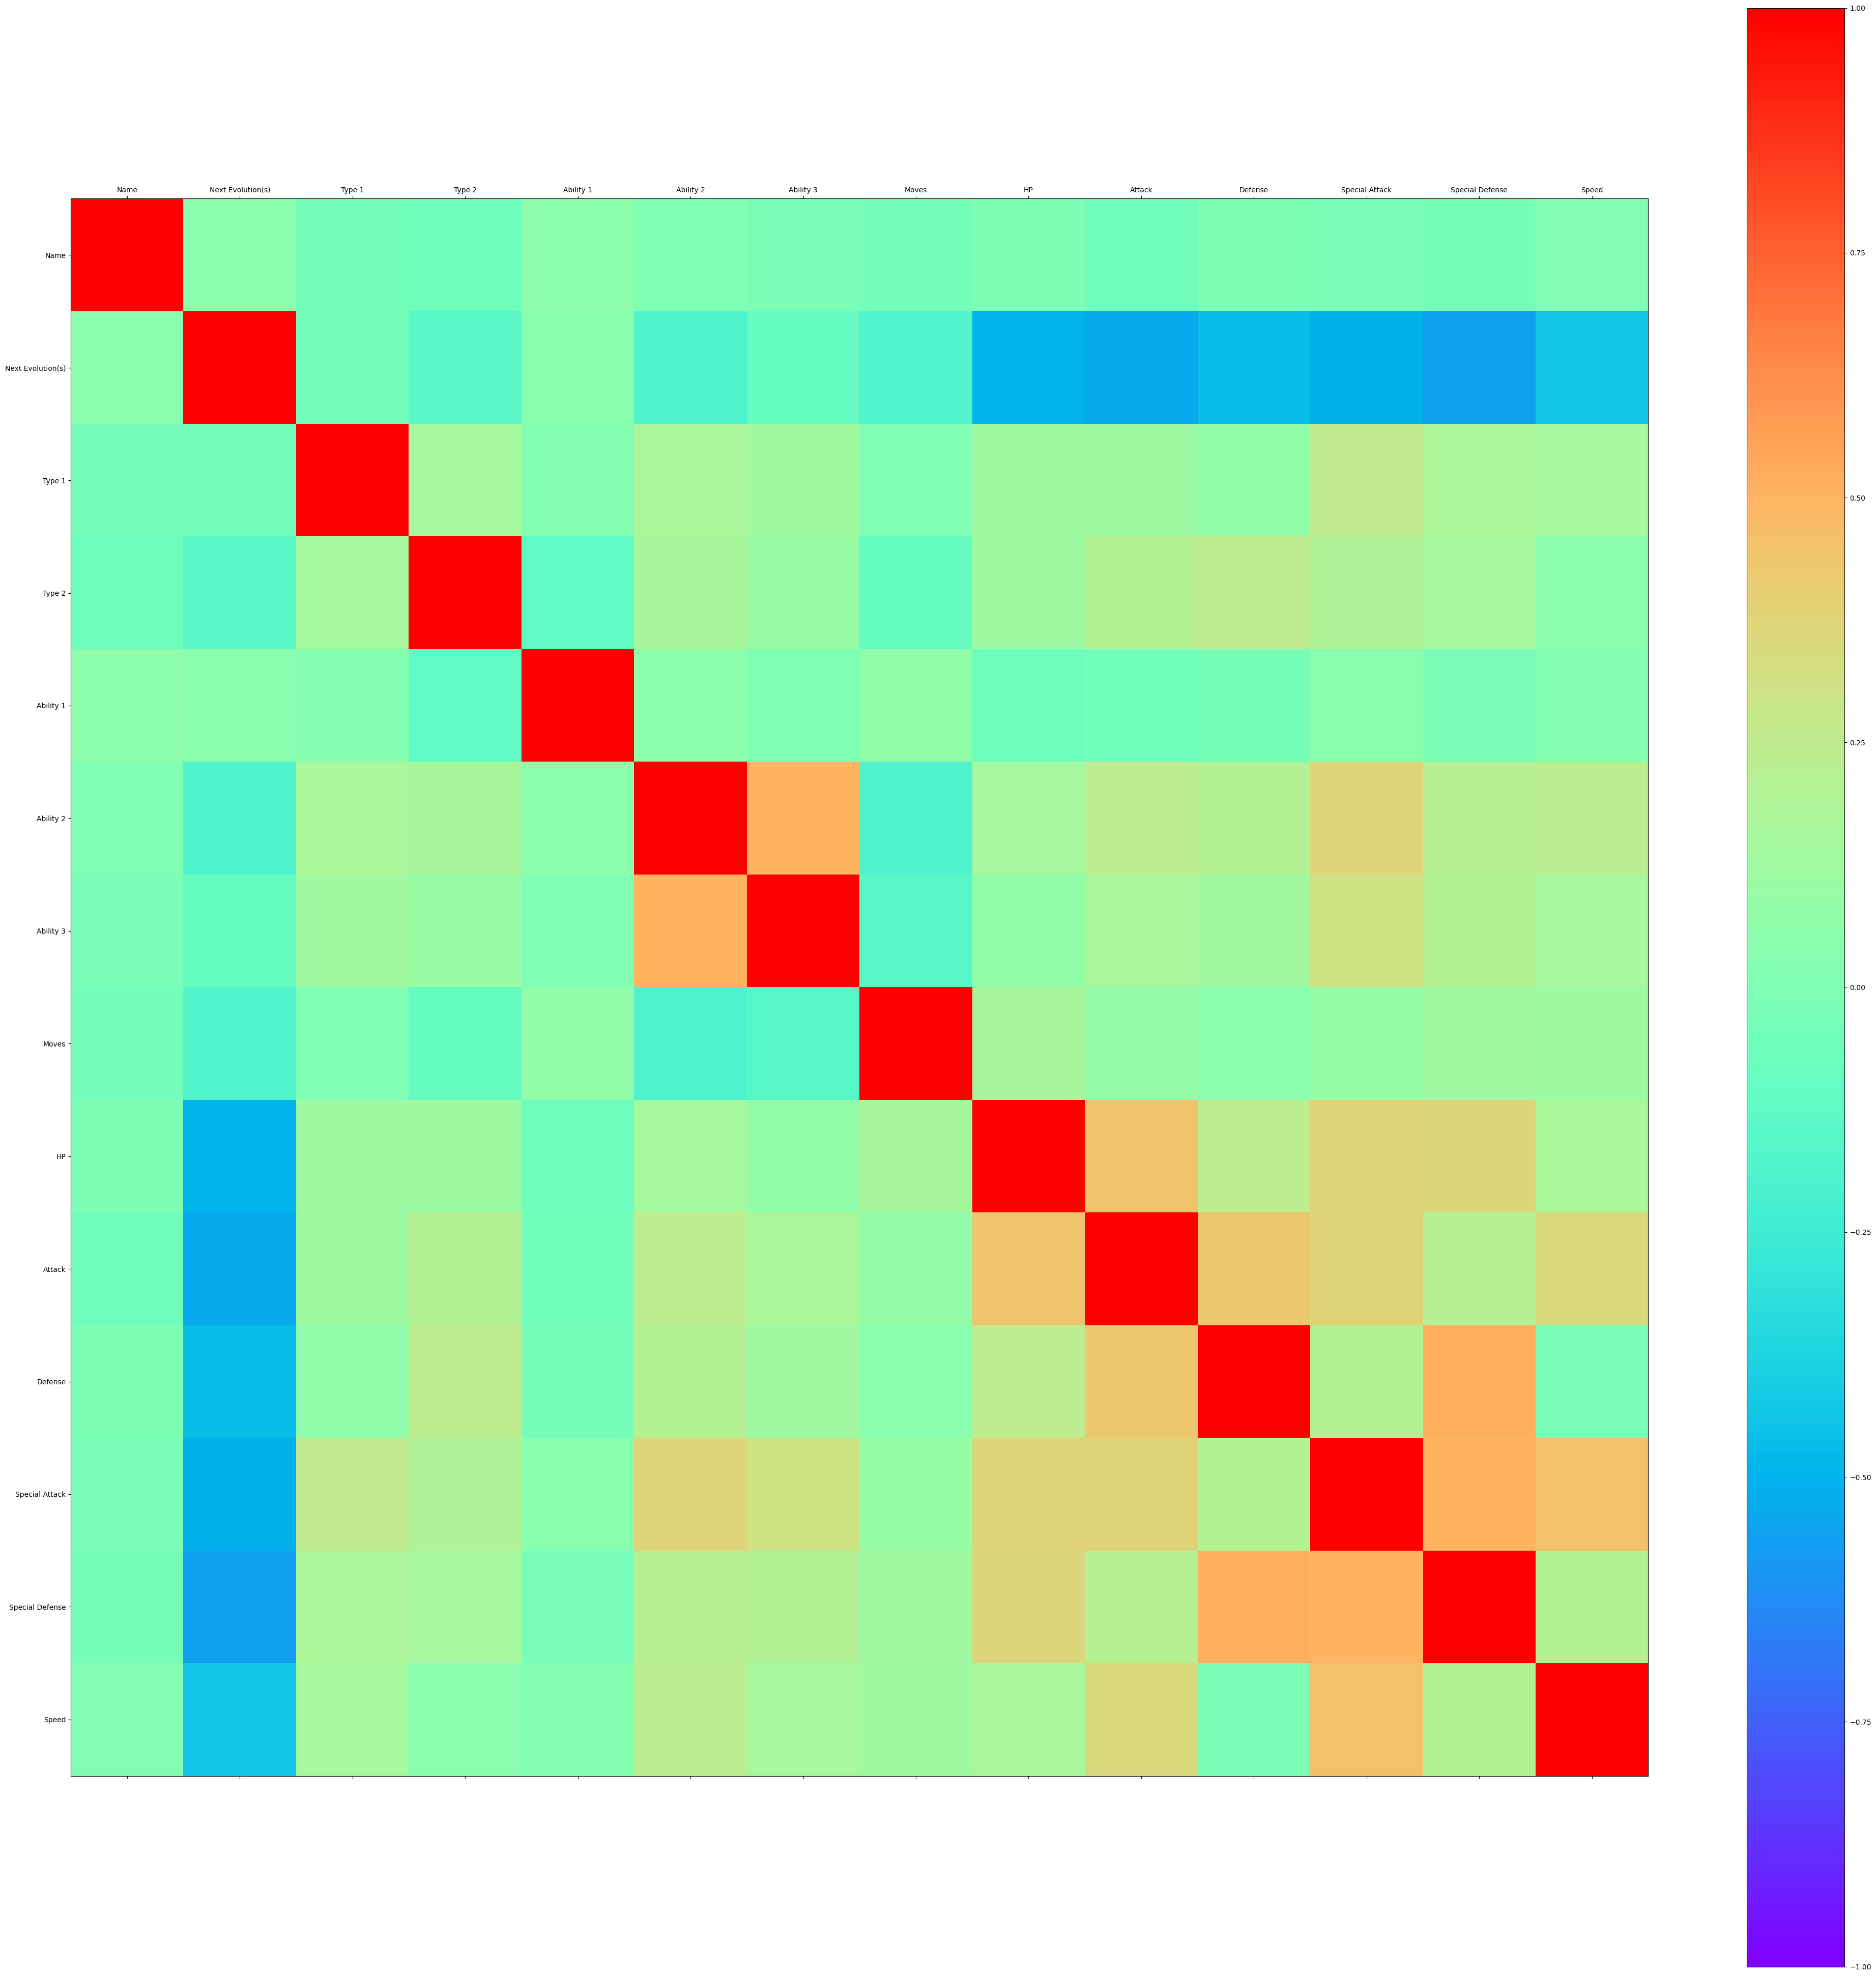

In [55]:
    correlaciones = X2.corr()

    # Mostramos la matriz de correlaciones especificando el rango de los valores [-1, 1]
    fig = plt.figure(figsize=(50,50))
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlaciones, vmin=-1, vmax=1, cmap=plt.cm.rainbow)
    fig.colorbar(cax)
    ticks = np.arange(0,len(X2.columns),1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    # Añadimos los nombres de las variables en la figura
    names = X2.columns
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

Hay dos grupos de correlaciones dignos de comentar.

Por un lado, vemos que la columna de "Next Evolution(s)" está correlacionada inversamente con las estadísticas (HP, Ataque, Defensa, Ataque Especial, Defensa Especial, Velocidad). Esto tiene sentido, ya que los Pokémon que todavía pueden evolucionar (los que tienen un 1 en dicha columna) suelen tener estadísticas más bajas que los Pokémon que ya no pueden evolucionar más.

Por otro lado, tenemos una cierta correlación directa entre varias de las estadísticas. El motivo es el mismo, un Pokémon "fuerte" tenderá a tener todas sus estadísticas más altas que un Pokémon "débil", ya que al evolucionar suelen aumentar todas las estadísticas.

No obstante, la correlación no parece superar en valor absoluto el valor 0.75 en ninguno de los dos casos descritos anteriormente, por lo que no vamos a eliminar ninguna variable por esta razón.

Ahora, vamos a realizar la selección de variables. Una primera idea intuitiva puede ser utilizar ANOVA, ya que ANOVA penalizará de cierta manera las variables de entrada correlacionadas entre sí (por lo que le quitaría peso a "Next Evolution(s)", probablemente). Sin embargo, un requisito indispensable para utilizar ANOVA es que las variables sigan una distribución normal. Por la forma en la que hemos construido algunas columnas (las de habilidades, la de evoluciones...), es muy improbable que sigan una distribución Gaussiana. De todas formas, para asegurarnos, vamos a utilizar el test de normalidad de Lilliefors (mejor que el de Shapiro-Wilk, ya que éste es más adecuado para mueestras pequeñas) y calcular el p-valor asociado a cada variable.

In [56]:
for var in X2.columns:
    p_valor = lilliefors(X2.loc[:,var], pvalmethod='approx')[1]
    print("Variable: "+var+", p-valor: "+str(p_valor))

Variable: Name, p-valor: 3.4773883099808566e-07
Variable: Next Evolution(s), p-valor: 0.0
Variable: Type 1, p-valor: 2.4765620282470368e-188
Variable: Type 2, p-valor: 7.321807663013641e-239
Variable: Ability 1, p-valor: 3.197040414123504e-47
Variable: Ability 2, p-valor: 0.0
Variable: Ability 3, p-valor: 4.7357117673737096e-281
Variable: Moves, p-valor: 3.568392190899791e-10
Variable: HP, p-valor: 7.250660490093164e-23
Variable: Attack, p-valor: 2.157882634517127e-08
Variable: Defense, p-valor: 1.09507583175715e-19
Variable: Special Attack, p-valor: 6.968217952056902e-25
Variable: Special Defense, p-valor: 3.850680926139844e-12
Variable: Speed, p-valor: 4.0235827295581974e-10


Como vemos, ninguna variable es remotamente normal, ya que sus p-valores son minúsculos. Por lo tanto, la selección de variables no la podemos realizar con ANOVA. Incluso realizando transformaciones logarítmicas o radicales, no se obtiene normalidad, por lo que es mejor probar con un filtro no paramétrico. Por ejemplo, `mutual_info_classif`. 

Este filtro toma como parámetros los datos de entrada, los datos de salida (en forma de array de strings o de integers, no como array de floats), un array con las posiciones de las variables que son discretas (en nuestro caso, sólo la columna "Next Evolution_1", que ocupa la posición 7) y el número de vecinos que tendrá en cuenta el filtro para seleccionar las variables (por defecto es . De e manera empírica, parece que valores altos de este parámetro (como n_neighbors = 20) arronja resultados más fiables (con n_neighbors < 4 le da más importancia al nombre que a alguna de las estadísticas, lo cual no tiene sentido, se mire como se mire).

In [57]:
y_transformed = y_transformed.astype(int) #Es necesario pasar a int para que mutual_info_classif funcione
informacion_mutua = mutual_info_classif(X2, y_transformed, discrete_features=[1], n_neighbors=20)

#Mostramos la información mutua  de todas las variables.
print("Información mutua de las variables: ")
i=0
for name in X2.columns:
    print(name+": "+str(informacion_mutua[i]*100)) #Multiplicamos por 100 para que se aprecien mejor las diferencias.
    i+=1

Información mutua de las variables: 
Name: 0.32006467816558803
Next Evolution(s): 3.672873652087559
Type 1: 2.3257959784689586
Type 2: 2.972326238946321
Ability 1: 3.273123903638009
Ability 2: 5.0871275243344005
Ability 3: 3.616571546863545
Moves: 0.6385205182477538
HP: 4.97676538745071
Attack: 6.7919577874552495
Defense: 5.129992684479134
Special Attack: 8.851121878952917
Special Defense: 4.817053047156428
Speed: 4.349771420972459


A partir de estos datos, observamos algo curioso con las habilidades. Como las habilidades "nulas" son las más comunes, el hecho de que un Pokémon no tenga segunda habilidad parece ser muy importante a la hora de determinar su potencial competitivo, como habíamos explicado anteriormente (los Pokémon legendarios no suelen tener más de una habilidad y suelen ser buenos, por lo que es lógico que se halle una relación entre la "Tier" y la presencia o no de segunda y tercera habilidad, que era la razón por la que habíamos escogido la codificación del conteo para dichas habilidades en primer lugar).

Vamos a utilizar la técnica de `SelectKBest` para seleccionar  las variables. Observamos una gran diferencia entre la información mutua de las variables "Name", "Moves" y el resto de variables. Por lo tanto, vamos a eliminar esas dos (es decir, escogemos $k = 12$ variables), ya que son significactivamente menos importantes que el resto.

In [58]:
#Para utilizar mutual_info_classif con los valores de los parámetros personalizados como función de score es necesario definirlo como 
#función previamente: https://stackoverflow.com/questions/44347683/how-to-set-parameters-to-score-function-in-sklearn-selectkbest
def mutual_info_classif_personalizado(X, y): #Esta función tiene que estar definida ANTES de la pipeline
    list_discrete_features=[1]
    neighbors=20
    return mutual_info_classif(X, y, discrete_features=list_discrete_features, n_neighbors=neighbors)

#Esto habría que omitirlo
"""selector = SelectKBest(mutual_info_classif_personalizado, k=12) #Esto se mete luego en la Pipeline (sólo esta línea).
X_seleccion = selector.fit_transform(X2, y_transformed)
nuevas_columnas = X2.columns[selector.get_support()]
X_seleccion = pd.DataFrame(X_seleccion)
X_seleccion.columns = nuevas_columnas
X_seleccion"""

'selector = SelectKBest(mutual_info_classif_personalizado, k=12) #Esto se mete luego en la Pipeline (sólo esta línea).\nX_seleccion = selector.fit_transform(X2, y_transformed)\nnuevas_columnas = X2.columns[selector.get_support()]\nX_seleccion = pd.DataFrame(X_seleccion)\nX_seleccion.columns = nuevas_columnas\nX_seleccion'

### Problema desbalanceado. Balanceo del problema con técnicas de over-sampling y under-sampling

In [59]:
n_malos = y_transformed[y_transformed==0].count()[0]
n_buenos = y_transformed[y_transformed==1].count()[0]
print("Pokémon malos: "+ str(n_malos))
print("Pokémon buenos: "+ str(n_buenos))
IR = n_malos/n_buenos
print("Imbalanced ratio conjunto total: " + str(IR))

Pokémon malos: 789
Pokémon buenos: 79
Imbalanced ratio conjunto total: 9.987341772151899


Como vemos, nuestro problema está desbalanceado, ya que tenemos muchos más Pokémon de la clase negativa (0) que de la clase positiva (1)

Con el fin de que el modelo aprenda mejor, vamos a utilizar una técnica que combina over-sampling y under-sampling. Esta aplica secuencialmente Synthetic minority over-sampling technique (SMOTE) como técnica de over-sampling y Tomek Links como técnica de under-sampling (aunque se centra más en eliminar ruido que en reducir el número de ejemplos) 

Puesto que nuestro tamaño de muestra no es demasiado grande (menos de 1000 ejemplos), nos vemos forzados a utilizar una técnica de over-sampling para generar nuevos ejemplos de la clase positiva. Hemos preferido evitar el random over-sampling por el **imbalanced ratio: 8.85**, ya que con un valor tan grande corremos el riesgo de generar sobre-aprendizaje. Sin embargo, SMOTE tiene el problema de generar muchos ejemplos en la frontera. Por lo que lo combinamos con la técnica de under-sampling Tomek-Links, para limpiarla. Tomek links ha sido escogida sobre ENN, ya que esta última es una técnica de under-sampling más agresiva, por lo que no es conveniente dado el moderado número de ejemplos de los que disponemos (<1000).

In [60]:
smt = SMOTETomek()
#Esto se omite
"""
X_train_res, y_train_res = smt.fit_resample(X_train, y_train.astype('int'))
X_train_res, y_train_res
"""

"\nX_train_res, y_train_res = smt.fit_resample(X_train, y_train.astype('int'))\nX_train_res, y_train_res\n"

### Creación de los conjuntos de entrenamiento, validación y test. Problema desbalanceado

Dividimos el conjunto de datos en entrenamiento, validación y test. Utilizamos **estratificación** para que la proporción de ejemplos de la clase 0 y la clase 1 se mantenga en los conjuntos de entrenamiento, validación y test (en entrenamiento no importa demasiado porque vamos a balancearlo con SMOTE+Tomek links pero sí que es importante que en validación y test la proporción de ejemplos de ambas clases sea similar). Puesto que no tenemos muchos ejemplos de la clase 1, vamos a hacer que la división sea 70% entrenamiento, 15% validación y 15% test, para que los conjuntos de validación y test sean más grandes y más fiables que de normal con el 80/10/10.

In [61]:
restoEjemplos_X, X_test, restoEjemplos_y, y_test =  train_test_split(X, y_transformed, stratify = y_transformed, test_size=0.15, random_state=123)
X_train, X_val, y_train, y_val =  train_test_split(restoEjemplos_X, restoEjemplos_y, stratify=restoEjemplos_y, train_size=0.823, random_state=123)

Vamos a comprobar que, en efecto, la proporción de ejemplos de ambas clases es parecida en los tres conjuntos. Para ello, utilizamos el Imbalanced Ratio (IR).

In [62]:
n_malos_train = y_train[y_train==0].count()[0]
n_buenos_train = y_train[y_train==1].count()[0]
n_malos_val = y_val[y_val==0].count()[0]
n_buenos_val = y_val[y_val==1].count()[0]
n_malos_test = y_test[y_test==0].count()[0]
n_buenos_test = y_test[y_test==1].count()[0]

IR_train = n_malos_train/n_buenos_train
print("Imbalanced ratio conjunto de entrenamiento: " + str(IR_train))
IR_val = n_malos_val/n_buenos_val
print("Imbalanced ratio conjunto de validación: " + str(IR_val))
IR_test = n_malos_test/n_buenos_test
print("Imbalanced ratio conjunto de test: " + str(IR_test))

Imbalanced ratio conjunto de entrenamiento: 10.018181818181818
Imbalanced ratio conjunto de validación: 9.916666666666666
Imbalanced ratio conjunto de test: 9.916666666666666


Mostramos esta información gráficamente en un histograma: 

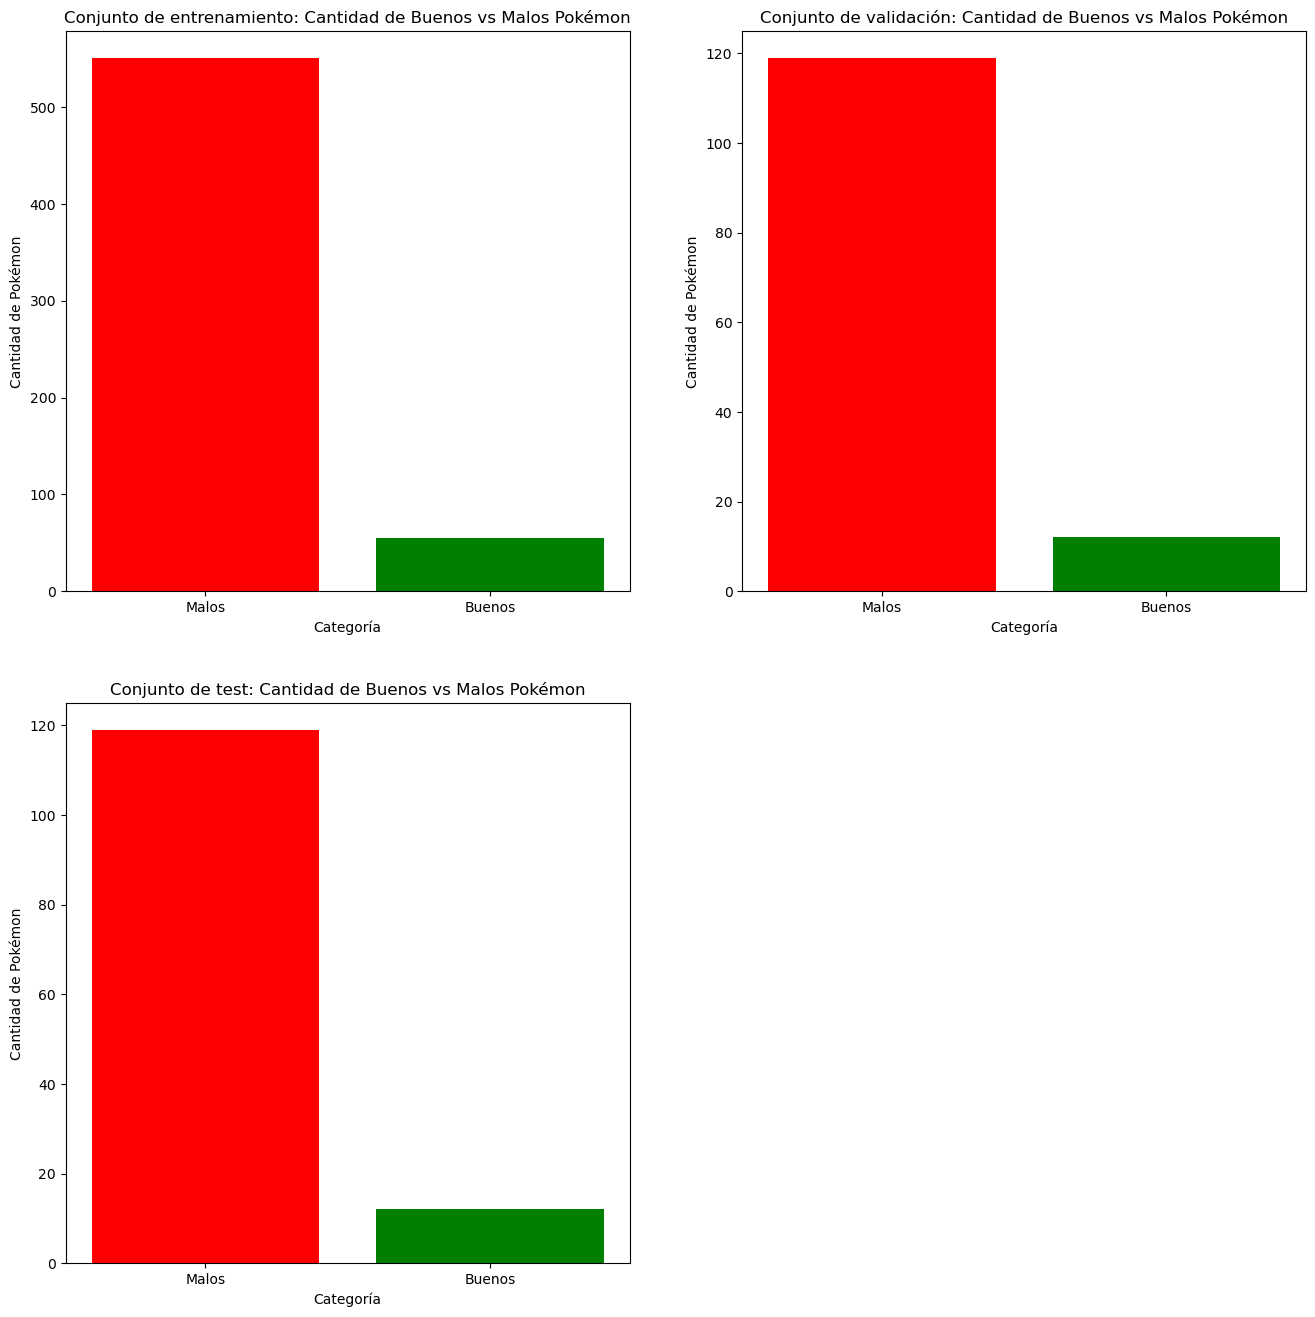

In [63]:
# Crear el histograma para buenos vs malos
plt.figure(figsize=(16, 16))

# Gráficos de barras de los Pokémon del conjunto de entrenamiento
plt.subplot(2,2,1)
plt.bar(['Malos', 'Buenos'], [n_malos_train, n_buenos_train], color=['red', 'green'])
plt.xlabel('Categoría')
plt.ylabel('Cantidad de Pokémon')
plt.title('Conjunto de entrenamiento: Cantidad de Buenos vs Malos Pokémon')

# Gráficos de barras de los Pokémon del conjunto de validación
plt.subplot(2,2,2)
plt.bar(['Malos', 'Buenos'], [n_malos_val, n_buenos_val], color=['red', 'green'])
plt.xlabel('Categoría')
plt.ylabel('Cantidad de Pokémon')
plt.title('Conjunto de validación: Cantidad de Buenos vs Malos Pokémon')

# Gráficos de barras de los Pokémon del conjunto de test
plt.subplot(2,2,3)
plt.bar(['Malos', 'Buenos'], [n_malos_test, n_buenos_test], color=['red', 'green'])
plt.xlabel('Categoría')
plt.ylabel('Cantidad de Pokémon')
plt.title('Conjunto de test: Cantidad de Buenos vs Malos Pokémon')

# Mostrar el gráfico
plt.show()

### Predicciones y evaluación

Una vez explicados y definidos todos los tratamientos que le vamos a realizar a nuestro conjunto de datos, podemos definir una Pipeline general que englobe el preprocesamiento, la estandarización, la selección de variables, el over-sampling y el clasficador KNN. Al estar utilizando SMOTE+Tomek links, es necesario que esta Pipeline sea de Imbalanced-learn en vez de Scikit-learn, ya que necesitará llamar al método `fit_resample` en vez de `fit_transform` para ese paso.

En la Pipeline no vamos a incluir las clases `OutlierDetecion_treatment_IQR` y `corr_selection`, ya que, como hemos explicado, no vamos a eliminar ningún outlier ni tampoco vamos a eliminar variables por motivos de correlación, por lo que no merece la pena añadirlas.

In [83]:
#Parámetros que se pueden toquitear: smoothing y min_samples_leaf del TargetEncoder(), cambiar el StandardScaler por MinMaxScaler
#el n_neighbors de mutual_info_classif_personalizado, el k de SeleckKBest, los parámetros de SmoteTomek
#Smote

pipe_global = Pipeline([('Preprocesamiento', preprocesamiento),
                       ('Estandarización', preprocessing.StandardScaler()),
                      ('Selección de variables', SelectKBest(mutual_info_classif_personalizado, k=12)),
                      #('SMOTE + Tomek links', SMOTETomek(random_state=123)),
                      ('Clasificador_KNN', neighbors.KNeighborsClassifier())])


pipe_global.fit(X_train, y_train) 
y_val_prediccion = pipe_global.predict(X_val)
y_val_prediccion=pd.DataFrame(y_val_prediccion)
y_val_prediccion.index = y_val.index
print(y_val_prediccion)

                  0
Name               
Salamence         1
Steelix           0
Scyther           0
Vikavolt          0
Grimer            0
Rayquaza          1
Poliwag           0
Tapu Bulu         0
Carracosta        0
Simisear          0
Luvdisc           0
Chansey           0
Torterra          0
Gyarados          0
Golbat            0
Pumpkaboo-Small   0
Glaceon           0
Bellossom         0
Armaldo           0
Empoleon          0
Kyogre            1
Rhyperior         0
Raticate-Alola    0
Litwick           0
Spritzee          0
Rhyhorn           0
Sentret           0
Tympole           0
Kabuto            0
Fomantis          0
Elgyem            0
Poochyena         0
Larvitar          0
Illumise          0
Minior            0
Mandibuzz         0
Seadra            0
Zapdos            0
Dialga            0
Lapras            0
Nidoqueen         0
Luxray            0
Shuckle           0
Piloswine         0
Raikou            0
Rockruff          0
Ariados           0
Dodrio            0


Definimos una función que nos ayuda a encontrar el mejor número de vecinos para KNN. Representamos los datos devueltos por esta función en un histograma.

In [84]:
def EncontrarMejorK(X_train,y_train,X,y,k=[i for i in range(1,11)]):
    scores = []
    accuracies = []
    mejor_f1 = 0
    
    for i in k:
        pipe_global.set_params(Clasificador_KNN__n_neighbors=i)
        pipe_global.fit(X_train, y_train) 
        y_pred = pipe_global.predict(X)
        f1 = metrics.f1_score(y.to_numpy().astype(int), y_pred)
        accuracy = (y.to_numpy().astype(int) == y_pred).mean()
        print(f"k={k[i-1]}  f1_score={np.round(f1, 4)}   accuracy={np.round(accuracy, 4)}")
        if f1 > mejor_f1:
            mejor_f1 = f1
            mejor_k = i
            prec_mejor_f1 = accuracy
        scores.append(f1)
        accuracies.append(accuracy)
    print(f"Mejor k={mejor_k}  f1_score={np.round(mejor_f1, 4)} accuracy={np.round(prec_mejor_f1, 4)}")
    return scores, accuracies


k=1  f1_score=0.6087   accuracy=0.8398
k=2  f1_score=0.0   accuracy=0.9084
k=3  f1_score=0.4444   accuracy=0.871
k=4  f1_score=0.375   accuracy=0.8835
k=5  f1_score=0.5263   accuracy=0.8648
k=6  f1_score=0.4706   accuracy=0.8772
k=7  f1_score=0.6316   accuracy=0.8648
k=8  f1_score=0.4706   accuracy=0.8772
k=9  f1_score=0.4706   accuracy=0.8772
k=10  f1_score=0.375   accuracy=0.8835
Mejor k=7  f1_score=0.6316 accuracy=0.8648


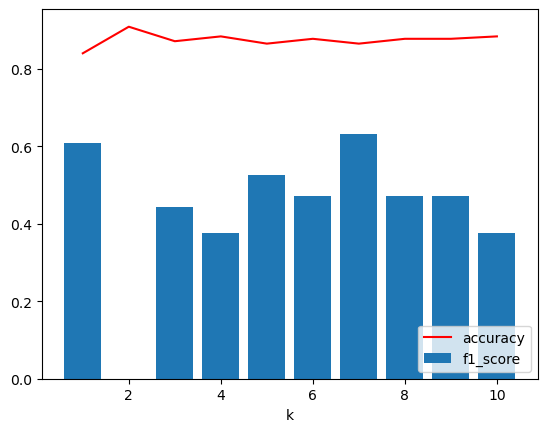

In [85]:
scores, accuracy = EncontrarMejorK(X_train,y_train,X_val,y_val,[i for i in range(1,11)])
plt.figure()
plt.bar([i for i in range(1,11)], scores, label='f1_score')
plt.plot([i for i in range(1,11)], accuracy, label='accuracy',c='r')
plt.xlabel('k')
plt.legend(loc='lower right');

##### score = metrics.f1_score(y_train, y_train_predict)